勾配降下法でポリタンクを探す
===
---

#### 参考URL
- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)
- [Goh, "Why Momentum Really Works", Distill, 2017.](https://distill.pub/2017/momentum/)

---
## 1. 準備
### 1.1. import

In [106]:
import sys
sys.path.append('..')
from geo_util import MapTile  # 地理院タイルを扱いやすくするために作った

import numpy as np
import itertools
from IPython.core.pylabtools import figsize
from matplotlib.patches import Polygon
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### 1.2. 関係する範囲の地理院タイルをダウンロード
- 各地点における標高をできるだけ細かく取得したい。
dem5a（航空レーザ測量）のズームレベル15がベストらしい。

    http://maps.gsi.go.jp/help/pdf/demapi.pdf

    ※ dem: 数値標高モデル（すうちひょうこうモデル、DEM; Digital Elevation Model) 


- 地理院タイルを取得するには「タイル座標」を指定する必要がある。 [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)で調べると、今回問題となる範囲はだいたい下図の範囲である。
<img src="xyz.png" width="300"></img>

In [2]:
# 標高タイル
#from_tile, to_tile = [15, 29044, 12928], [15, 29051, 12935]
from_tile, to_tile = [15, 29047, 12929], [15, 29049, 12931]
nabewari_tile = MapTile(from_tile, to_tile, zoom=15, tile_type="dem5a", ext="txt")  # MapTileクラスは../geo_util.pyに定義

In [3]:
# 比較用　に、同じエリアの標準地図を取得する
#nabewari_map = MapTile([13, 7261, 3232], [13, 7262, 3233], zoom=13, tile_type="std", ext="png")
nabewari_map = MapTile(from_tile, to_tile, zoom=15, tile_type="std", ext="png")

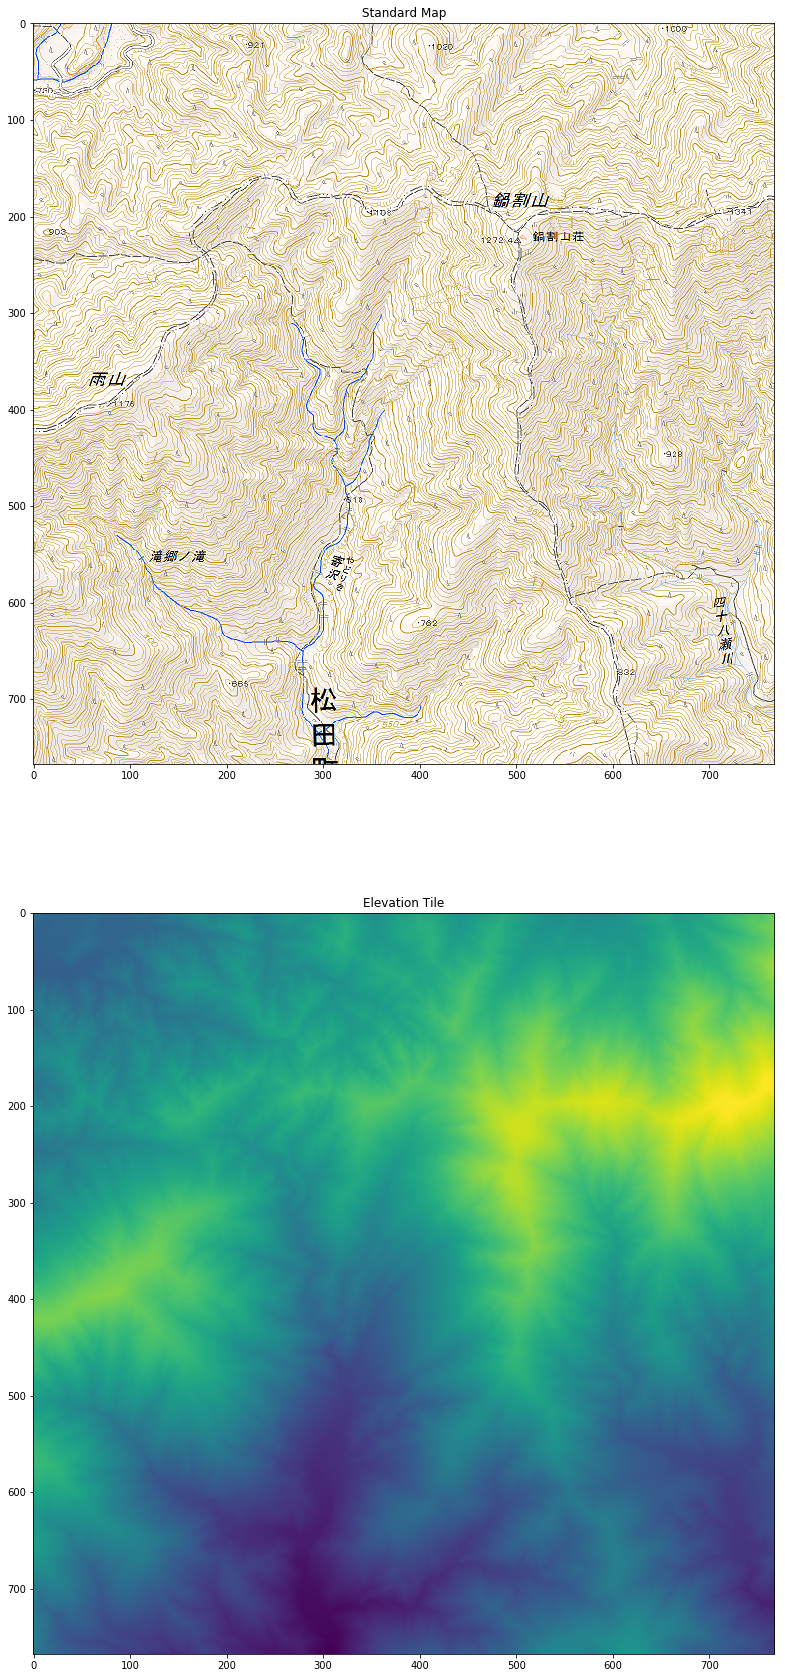

In [4]:
figsize(15, 30)
f, axarr = plt.subplots(2, 1)
# 標準地図
axarr[0].set_title("Standard Map")
axarr[0].imshow(nabewari_map.data)
# 同じエリアの標高タイル
axarr[1].set_title("Elevation Tile")
axarr[1].imshow(nabewari_tile.data, interpolation="none")

### 1.3. ポリタンクを落とした地点の座標を取得
現場の写真のExifより、以下の地点（緯度経度）で落としたことが分かっている。

In [5]:
start_lat, start_lon = 35.437, 139.141

### 1.4. 緯度経度をピクセル座標に変換
ポリタンクを落とした地点の緯度経度は既知だが、地理院タイルのindexとの対応が分からなければプロットできない。以下のように緯度経度をピクセル座標に変換し、当面はピクセル座標に基づいて考えてゆく。

参考：http://www.trail-note.net/tech/coordinate/

In [6]:
def latlon_to_pixel(lat, lon, zoom):
    """ 緯度・経度をズームレベルzoomのもとでピクセル座標に変換する """
    L = 85.05112878
    x = 2**(zoom+7) * (1 + lon/180.)
    y = 2**(zoom+7) / np.pi * (- np.arctanh(np.sin(np.pi*lat/180.)) + np.arctanh(np.sin(np.pi*L/180.)))
    return x, y

In [7]:
start_x, start_y = latlon_to_pixel(start_lat, start_lon, 15)  # ピクセル座標
print("pixel (x, y) = ({}, {})".format(start_x, start_y))

pixel (x, y) = (7436524.293688889, 3310245.05258863)


これをダウンロードしてきた地理院タイル（`nabewari_tile`）のindexに変換する。

普通なら256で割った余りを取れば良いが、`nabewari_tile`は複数の地理院タイルを結合したものであることに注意する。

In [8]:
start_x = start_x - 256*from_tile[1]
start_y = start_y - 256*from_tile[2]
print(start_x, start_y)

492.29368888866156 421.05258863


- indexに変換できたので、地図と合わせてプロットする。

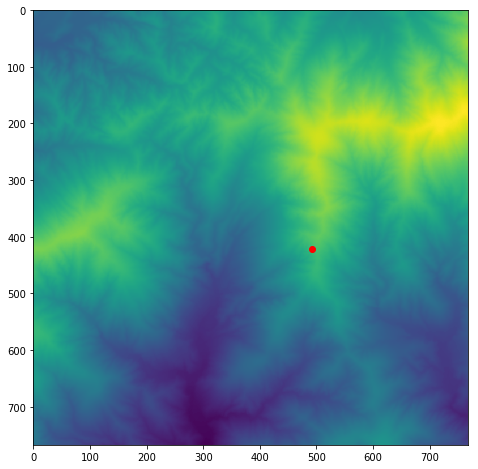

In [9]:
figsize(8, 8)
plt.imshow(nabewari_tile.data) # 標高タイルをプロット
plt.scatter(start_x, start_y, color="red") # ポリタンクを落とした位置も重ねてプロット

- 確かにポリタンクを落とした位置にプロットできている（目視確認）


以下では、この地点からのポリタンクの移動を勾配降下法に基づいて計算する。

---
## 2. 勾配降下法
<img src="gradient_descent.png" width="600"></img>
画像：[Goh, "Why Momentum Really Works", Distill, 2017.](https://distill.pub/2017/momentum/)

### 2.1. 原理

初期地点を$(x_0, y_0)$として、以下のように勾配（偏微分）に基づいて移動を行う。$\epsilon$は1ステップごとの移動量を決めるパラメータである。

$$
\left( \begin{array}{cc} x_{k+1}\\ y_{k+1}\\ \end{array} \right) = 
\left( \begin{array}{cc} x_{k}\\ y_{k}\\ \end{array} \right) - \epsilon \:
\left( \begin{array}{cc} \left. \frac{\partial z}{\partial x} \right|_{(x, y)=(x_k, y_k)} \\
                         \left. \frac{\partial z}{\partial y} \right|_{(x, y)=(x_k, y_k)} \\ \end{array} \right)
$$

上記のような移動を行うには任意の地点における勾配を計算する必要がある。

### 2.2. 勾配の計算方法
地理院タイルは格子点上の標高に関する情報しか与えてくれていない（下図の正方形の頂点）。
その隙間を含む任意の地点$(x, y)$での勾配を知りたい（ポリタンクは格子点上だけを転がってくれる訳ではない）ので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。

<img src="https://raw.githubusercontent.com/sw1227/geospatial_analysis/master/fig/grad.png" width="300"></img>

(1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

   3点 $([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$


(2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

   3点 $([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$ を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

(1), (2)いずれの場合でも、勾配は隣の格子点同士の高さを単純に引き算したものになっている。

### 2.3. 勾配降下法の修正
勾配降下法をそのまま適用するのはあまりに単純すぎるので、以下のような修正を加えることにする。

####  (i) ランダムな方向転換
地理院タイルの分解能に現れない細かな地形や樹木等の影響に対応。

実装上は、平均0, 標準偏差 `direction_scale` $[rad]$ の正規分布に従う方向転換が行われるものとする。
すなわち、以下のような回転行列に基づいて位置の更新量が回転される。
$$
\left(\begin{array}{cc} cos \theta & -sin \theta \\ sin \theta & cos \theta \\ \end{array} \right),\:\:\:
\theta \sim Normal(0,\: direction\_scale)
$$

例えば `direction_scale`を$\pi / 12 [rad]$にすると、方向転換が正面から±15度の範囲に収まる確率は68%となる。

####  (ii) モメンタム（参考：["Why Momentum Really Works"](https://distill.pub/2017/momentum/)）
ポリタンクの移動速度は、現在地での勾配だけでなく過去の速度にも依存する。慣性。



※ (i) - (ii)に伴い、$\epsilon$だけでなく以下のようなパラメータを設定する必要が生じる。

- ランダムな方向転換の程度（`direction_scale` $[rad]$）
- 速さに応じた停止確率$p_{stop}(v)$を定めるパラメータ$\lambda$
- モメンタムの程度（["Why Momentum Really Works"](https://distill.pub/2017/momentum/)の$\beta$）

#### 修正後の更新則
修正(i), (ii)を考慮すると、初期位置$(x_0, y_0)$からの移動は以下の漸化式によって表現することができる。

$$
\left( \begin{array}{cc} z_{k+1}\\ w_{k+1}\\ \end{array} \right) = \beta \:
\left( \begin{array}{cc} z_{k}\\ w_{k}\\ \end{array} \right) +
\left( \begin{array}{cc} \left. \frac{\partial z}{\partial x} \right|_{(x, y)=(x_k, y_k)} \\
                         \left. \frac{\partial z}{\partial y} \right|_{(x, y)=(x_k, y_k)} \\ \end{array} \right)
$$

$$
\left( \begin{array}{cc} x_{k+1}\\ y_{k+1}\\ \end{array} \right) = 
\left( \begin{array}{cc} x_{k}\\ y_{k}\\ \end{array} \right) - \epsilon \:
\left(\begin{array}{cc} cos \theta_k & -sin \theta_k \\ sin \theta_k & cos \theta_k \\ \end{array} \right)
\left( \begin{array}{cc} z_{k+1}\\ w_{k+1}\\ \end{array} \right)
$$

$$
\theta_k \sim Normal(0,\: direction\_scale)
$$


#### (iii) ランダムな停止判定
勾配降下法は局所最小値に到達する（その地点での勾配が0になる）まで停止しないが、ポリタンクは障害物等によって斜面上で停止する可能性がある。

速さを$v = \sqrt{(x_{k+1} - x_{k})^2 + (y_{k+1} - y_{k})^2}$として以下のように考える。

- 速さ$v=0$の時は確率1で必ず停止する
- 速さ$v>0$の時も停止する可能性があり、その確率$p_{stop}(v)$は$v$の増加に対して単調減少かつ0に漸近する。

これらの条件を満たす停止確率$p_{stop}(v)$は、例えば以下のように設定できる。

$$
p_{stop}(v) = e^{-\lambda v}
$$

パラメータ$\lambda$が大きいほど以下のように停止確率は小さくなる。

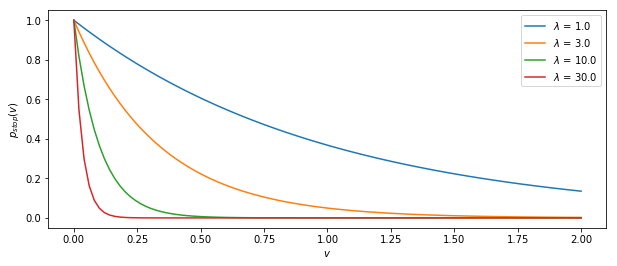

In [10]:
# いくつかのパラメータλに対し、速さと停止確率の関係をプロット
figsize(10, 4)
lambdas = [1.0, 3.0, 10.0, 30.0]
for l in lambdas:
    x = np.linspace(0.0, 2.0, 100)
    y = np.exp(- l * x)
    plt.plot(x, y, label="$\lambda$ = {}".format(l))
plt.xlabel("$v$")
plt.ylabel("$p_{stop}(v)$")
plt.legend()

### 2.4. 勾配降下法の実装
勾配$\frac{\partial z}{\partial x}, \frac{\partial z}{\partial y}$の計算自体は、`../geo_util.py`の`MapTile`クラスの`.grad(x, y)`メソッドに実装済。

ここでは、初期位置やパラメータを指定すると勾配降下法によってポリタンクの軌道を計算してくれる`TankTrajectory`クラスを作成する。

各パラメータは変更可能だが、真の値は分からないので、後ほど様々な値を与えた上で集計する。

In [11]:
def rotated(x, y, theta):
    """ ベクトル(x, y)を角度thetaだけ回転させる。方向転換に使用する """
    rotation_matrix = np.matrix(((np.cos(theta), -np.sin(theta)),
                                 (np.sin(theta), np.cos(theta))))
    return np.array(rotation_matrix.dot(np.array([x, y])))[0]

In [12]:
class TankTrajectory():
    """ 初期位置と標高タイルとパラメータを指定して勾配降下法を実行するクラス
    Input:
        start: 転がり始める地点のピクセル座標のタプル（標高タイルのindexと対応させておく）
        maptile: 勾配降下法を実行する標高タイル
        epsilon: 1stepごとの位置の更新量に影響するパラメータ
        max_step: 最大ステップ
        stop_lambda: 停止条件の数式のλ
        momentum: モメンタムの係数（"Why Momentum Really Works"のβ）
        direction_scale: ランダムな方向転換の角度の標準偏差
    Attribute: .run()を実行すると、得られた軌道に基づいて以下の属性がセットされる
        .x_list: 軌道の各stepにおけるx座標のリスト
        .y_list: 軌道の各stepにおけるy座標のリスト
        .vel_list: 軌道の各stepにおける速度のリスト
        .end_x: 軌道の終点におけるx座標
        .end_y: 軌道の終点におけるy座標
    """
    
    def __init__(self, start, maptile, epsilon, max_step, stop_lambda, momentum=0.0, direction_scale=0.0):
        """ Constructor """
        self.start_x, self.start_y = start
        self.maptile = maptile
        self.epsilon = epsilon
        self.max_step = max_step
        self.stop_lambda = stop_lambda
        self.momentum = momentum
        self.direction_scale = direction_scale

    def run(self):
        """ 勾配降下法を実行 """
        x, y = self.start_x, self.start_y
        self.x_list, self.y_list = [x], [y]
        self.vel = 0
        self.vel_list = [self.vel]
        z, w = 0.0, 0.0  # for momentum

        for step in range(self.max_step):
            try:
                gx, gy = self.maptile.grad(x, y)
            except IndexError: # タイルからはみ出した
                break
            #  勾配降下法 (+ momentum)に基づいて速度（このステップにおける位置の更新量）を計算
            z = self.momentum*z + gx
            w = self.momentum*w + gy
            # 速度をランダムに回転させる
            theta = np.random.normal(loc=0.0, scale=self.direction_scale)
            dx, dy = self.epsilon * rotated(z, w, theta)
            # 位置を更新
            x = x - dx
            y = y - dy
            # 速さを計算
            self.vel = np.sqrt(dx**2 + dy**2)
            #  軌道・速さを保存
            self.x_list.append(x)
            self.y_list.append(y)
            self.vel_list.append(self.vel)
            # 停止判定
            if self.is_stopped():
                break

        # 停止時の座標
        self.end_x, self.end_y = x, y

    def is_stopped(self):
        """ 停止判定 """
        prob_stop = np.exp( - self.stop_lambda*self.vel)
        # 確率prob_stopで停止。初期状態では停止しない
        return len(self.vel_list) > 1 and np.random.random() < prob_stop

- 使ってみる

In [13]:
# パラメータはとりあえず適当な値
t1 = TankTrajectory((start_x, start_y), nabewari_tile, epsilon=0.1, max_step=100000, stop_lambda=10, momentum = 0.9, direction_scale=np.pi/12)
t1.run()
print("stopped at step={}".format(len(t1.vel_list)-1))

stopped at step=230


- 実行結果を可視化してみる

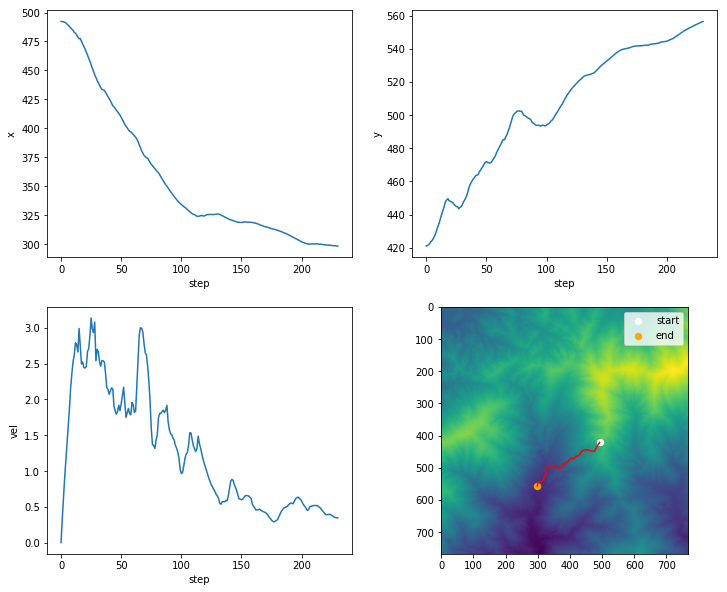

In [14]:
figsize(12, 10)
f, axarr = plt.subplots(2, 2)

# xの推移
axarr[0][0].plot(t1.x_list)
axarr[0][0].set_xlabel("step")
axarr[0][0].set_ylabel("x")
# yの推移
axarr[0][1].plot(t1.y_list)
axarr[0][1].set_xlabel("step")
axarr[0][1].set_ylabel("y")
# 速度の推移
axarr[1][0].plot(t1.vel_list)
axarr[1][0].set_xlabel("step")
axarr[1][0].set_ylabel("vel")
# 軌道をプロット
axarr[1][1].plot(t1.x_list, t1.y_list, color="red")
axarr[1][1].scatter(t1.start_x, t1.start_y, color="white", s=40, label="start")
axarr[1][1].scatter(t1.end_x, t1.end_y, color="orange", s=40, label="end")
axarr[1][1].legend()
axarr[1][1].imshow(nabewari_tile.data)

---
## 3. ランダムな初期位置の生成
勾配降下法を実行する準備が整ったので、これを

- 様々な初期位置（GPSの誤差などの不確実性があるので）
- 様々なパラメータ（真の値はよく分からないので）

で実行していくことになる。まずは様々な初期位置を生成する。

ポリタンクを落とした位置の推定座標をピークとしてもつ対称な二次元正規分布をベースとするが、ポリタンクが西側に転がったことは既知なので、東側に転がってしまうような初期位置はあとで除外する。

In [15]:
# (x_0, y_0)は無相関として、別々の一次元正規分布から生成すれば良い
init_pos_uncertainty = 7 # 初期位置の不確実性（標準偏差）：以下のセルでプロットした時の広がりと現場周辺の地形に関する知識から値を決めた
start_x_list = np.random.normal(loc=start_x, scale=init_pos_uncertainty, size=100)
start_y_list = np.random.normal(loc=start_y, scale=init_pos_uncertainty, size=100)
start_list = np.c_[start_x_list, start_y_list]

- 生成した初期位置を地図と重ねてプロットしてみる

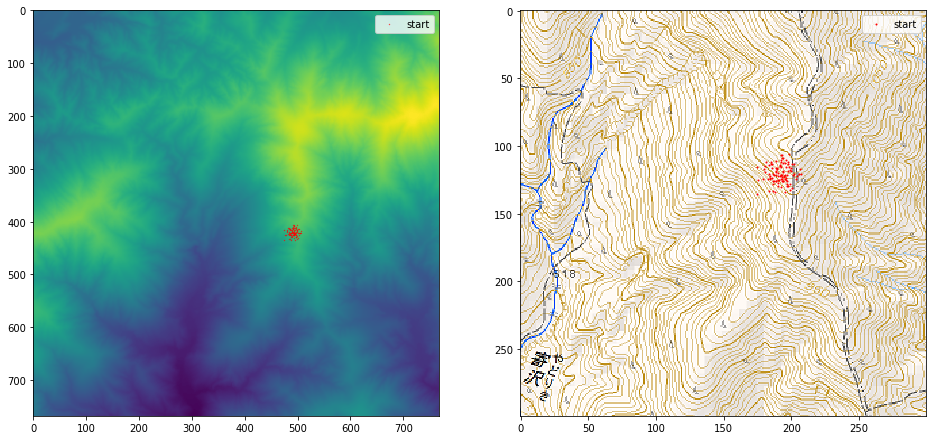

In [16]:
figsize(16, 8)
f, axarr = plt.subplots(1, 2)
# 標高タイル+初期位置
axarr[0].imshow(nabewari_tile.data)
axarr[0].scatter(start_list[:, 0], start_list[:, 1], s=0.1, color="red", label="start")
axarr[0].legend()
# 標準地図+初期位置　ズームする
axarr[1].imshow(nabewari_map.data[300:600, 300:600])
axarr[1].scatter(start_list[:, 0]-300, start_list[:, 1]-300, s=1, color="red", label="start")
axarr[1].legend()

---
## 4. 様々なパラメータ・初期位置で勾配降下法を実行
前章で生成した様々な初期位置のそれぞれについて、転がり方に関する様々なパラメータ（真の値はよく分からないので）を与えて勾配降下法を実行する。

各パラメータの値は常識的な範囲で変化させるが、計算時間の関係で、ひとつのパラメータにつき数個の値だけを用意する。

### 4.1. パラメータの組み合わせを生成

In [17]:
epsilons = [0.03, 0.1, 0.3, 0.5]
stop_lambdas = [1.0, 3.0, 10.0, 30.0]
momentums = [0.0, 0.5, 1.0]
direction_scales = [0.0, np.pi/12, np.pi/6]

# 全てのパラメータの組み合わせを生成
parameters = list(itertools.product(epsilons, stop_lambdas, momentums, direction_scales))
print("パラメータの組み合わせ：{}通り".format(len(parameters)))
print("パラメータの組み合わせの例：(epsilon, stop_lambda, momentum, direction_scale) = {}".format(parameters[0]))

パラメータの組み合わせ：144通り
パラメータの組み合わせの例：(epsilon, stop_lambda, momentum, direction_scale) = (0.03, 1.0, 0.0, 0.0)


### 4.2. すべての初期位置・パラメータのもとで勾配降下法を実行して軌道を計算

In [18]:
trajectory_list = []
# 様々な初期値に対してループ。tqdmは進捗表示用
for sx, sy in tqdm(start_list):
    # さらに、全てのパラメータの組み合わせについてループ
    for e, l, m, d in parameters:
        trajectory = TankTrajectory((sx, sy), nabewari_tile, epsilon=e, max_step=100000,
                                    stop_lambda=l, momentum = m, direction_scale=d)
        trajectory.run()
        trajectory_list.append(trajectory)

print("計算した軌道の総数: {}".format(len(trajectory_list)))

HBox(children=(IntProgress(value=0), HTML(value='')))


計算した軌道の総数: 14400


### 4.3. 計算した軌道のフィルタリング
計算した軌道のそれぞれについて、ポリタンクの終着点を地図と重ねてプロットしてみる。

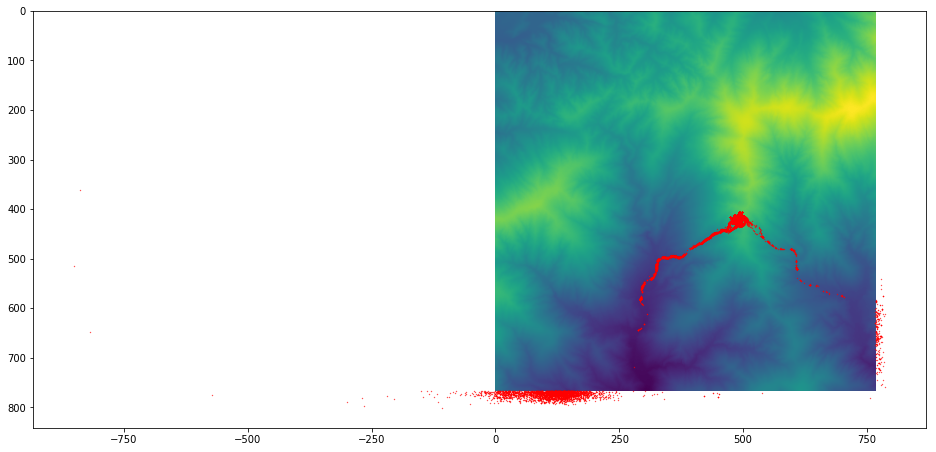

In [19]:
# ポリタンクの終着点のリスト
end_list = np.array([(t.end_x, t.end_y) for t in trajectory_list])

# プロット
figsize(16, 8)
plt.imshow(nabewari_tile.data)
plt.scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red")

パラメータの組み合わせによっては地図からはみ出してしまっていることがわかる。これらの軌道は常識的に考えられないので除外することにする。

また、以下の軌道も除外する。

- 東側に転がってしまっている軌道（西側に転がったことが分かっているので）
- 最初の数ステップで止まってしまった軌道（しばらくは転がり続けたことが分かっているので）

In [20]:
# 東側に転がったもの・はみ出したものを除く
filtered_list = [t for t in trajectory_list if 0<t.end_x<t.start_x and 300 < t.end_y < 768-1]
# 最初の10ステップ程度で止まってしまったものも除く
filtered_list = [t for t in filtered_list if len(t.vel_list) > 10]
print("フィルタリング後の軌道の総数: {}".format(len(filtered_list)))

フィルタリング後の軌道の総数: 5155


### 4.4. フィルタリング後の軌道の終着点をプロット
フィルタリング後の軌道のそれぞれについて、ポリタンクの終着点を今度は標準地図と重ねてプロットしてみる。

上方では初期位置の不確実性を反映してバラついているものの、転がり続けるにつれて清兵衛ノ沢から寄沢へと続く一本のラインへと収束していることが見て取れる。

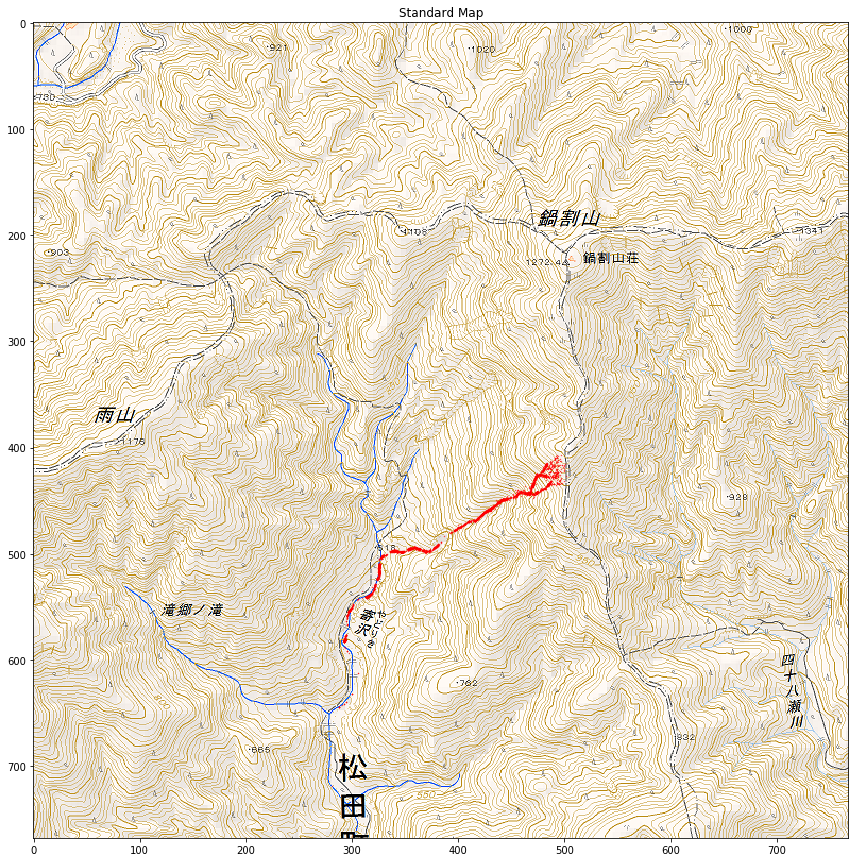

In [21]:
# ポリタンクの終着点のリスト
end_list = np.array([(t.end_x, t.end_y) for t in filtered_list])

# プロット
figsize(15, 15)
plt.title("Standard Map")
plt.imshow(nabewari_map.data)
plt.scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red")

---
## 5. カーネル密度推定によるポリタンク存在確率の可視化
前章では様々な初期位置・パラメータのもとで勾配降下法を実行した時のポリタンクの終着点を計算することができた。

これらの終着点のデータを使い、「各地点でポリタンクが停止した確率」を表したヒートマップを作成したい。終着点のサンプル点からヒートマップを作成するためにカーネル密度推定を行う。

> カーネル密度推定（カーネルみつどすいてい、英: Kernel density estimation）は、統計学において、確率変数の確率密度関数を推定するノンパラメトリック手法のひとつ。
>
> [カーネル密度推定 - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%BC%E3%83%8D%E3%83%AB%E5%AF%86%E5%BA%A6%E6%8E%A8%E5%AE%9A)

### 5.1. 方法
前章までの勾配降下法で得られたポリタンク終着点に関する$N$個のサンプルを

$$
(x_i, y_i), \:\: i = 1, 2, ..., N
$$

とする。地図上の任意の点 $(x, y)$ における、カーネル関数がガウス関数・バンド幅（平滑化パラメータ）が $h$ のカーネル密度推定量 $\hat{f}_{h}(x, y)$ は、以下のように計算できる。

$$
\hat{f}_{h}(x, y) \propto \sum_{i=1}^{N} \frac{1}{\sqrt{2\pi h^2}} exp \bigl(-\frac{(x - x_i)^2}{2 h^2}\bigr) \cdot \frac{1}{\sqrt{2\pi h^2}} exp \bigl(-\frac{(y - y_i)^2}{2 h^2} \bigr)
$$

- 実際の確率密度関数ではなくヒートマップを得ることが目的なので、カーネル密度推定量に比例した量が得られれば良いことに注意
- 多次元正規分布を使った表記にしていないのは、一次元正規分布の確率密度関数`scipy.stats.norm`を使ったシンプルな実装に対応させるため


### 5.2. 実装

In [22]:
def kde(points, bandwidth):
    """ points(標本)から点(x, y)における確率密度(に比例する量)をカーネル密度推定により計算し、それを要素にもつarrayを返す """
    density = np.zeros(nabewari_tile.shape)
    X, Y = np.meshgrid(np.arange(nabewari_tile.shape[0]), np.arange(nabewari_tile.shape[0]))
    for loc_x, loc_y in tqdm(points):
        d = stats.norm.pdf(X, loc=loc_x, scale=bandwidth) * stats.norm.pdf(Y, loc=loc_y, scale=bandwidth)
        density += d
    return density

In [23]:
heatmap = kde(end_list, bandwidth=5)

HBox(children=(IntProgress(value=0, max=5155), HTML(value='')))

### 5.3. 結果
#### 5.3.1. ヒートマップを表示
カーネル密度推定によって得られたヒートマップを表示してみる

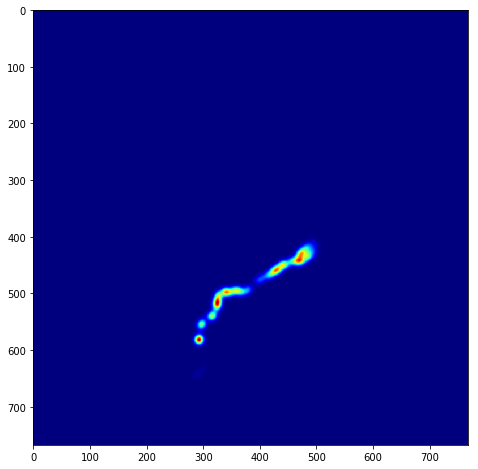

In [24]:
figsize(8, 8)
plt.imshow(heatmap, interpolation="none", cmap="jet")

#### 5.3.2. 地図と重ねて表示
ヒートマップを地図と重ねて表示したい。

- まずはヒートマップをRGB画像（値の範囲は0.0 - 1.0）に変換する。

(768, 768, 3)


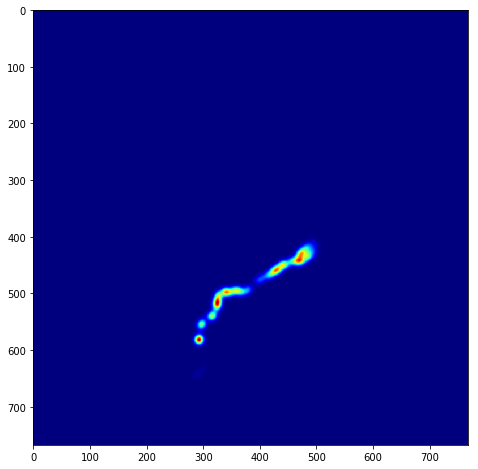

In [25]:
cmap=plt.cm.jet
normalize = plt.Normalize(vmin=heatmap.min(), vmax=heatmap.max())
heatmap_img = cmap(normalize(heatmap))[:, :, :3]  # normalizeしてalphaを除く
plt.imshow(heatmap_img)
print(heatmap_img.shape)

- 鍋割山の標準地図のデータはuint8で0-255の整数値をとるので、ヒートマップと同じ0.0 - 1.0に正規化する。

In [26]:
standard_map = nabewari_map.data / 255.

- ヒートマップと標準地図を$\alpha$ブレンドして表示

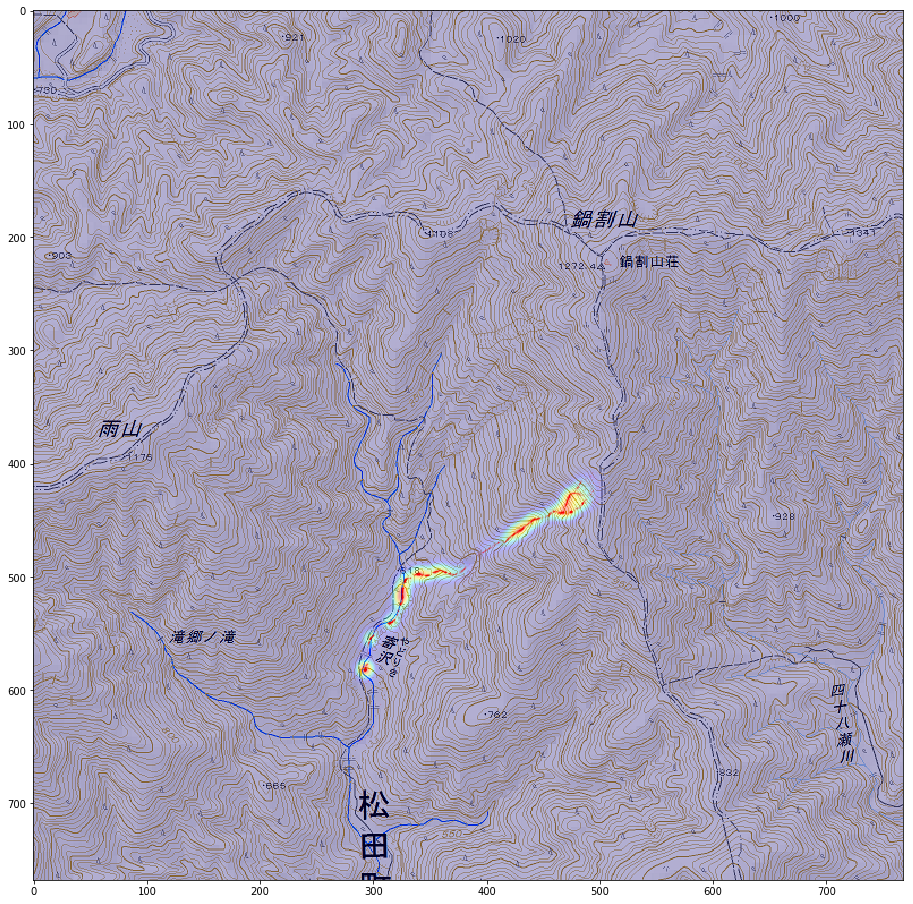

In [27]:
alpha = 0.3 # αブレンドのα
mixed_map = alpha * heatmap_img + (1.0-alpha) * (standard_map)

# プロット
figsize(16, 16)
plt.imshow(mixed_map)
plt.scatter(end_list[:, 0], end_list[:, 1], s=0.1, color="red", alpha=0.1) # 終着点のサンプルデータもうっすら表示させる

この図をもとにポリタンク捜索の旅に出る。

- ブレンドしたヒートマップを保存しておく

In [28]:
plt.imsave("heatmap.png", mixed_map)
!ls

gradient_descent.png       xyz.png
heatmap.png                yamap_2017-12-15_12_21.gpx
search_platic_tank.ipynb


---
## 6. 実地調査
だいたいどこにありそうか分かったので、2017/12/15に現場に向かった。

当日の行程は登山記録アプリYAMAPで記録してあり、GPSのログ（yamap_2017-12-15_12_21.gpx）も以下のページから辿って取得することができる。

https://yamap.co.jp/activity/1425779

このファイルと同じディレクトリに上記gpxファイルを（手動で）保存し、行程をヒートマップと重ねてプロットしてみる。

### 6.1. GPXファイルから行程を取り出す

GPXファイルはXMLベースなので、BeautifulSoupを用いて位置情報を取り出す。

In [30]:
name = "yamap_2017-12-15_12_21.gpx"
with open(name, "r") as f:
    soup = BeautifulSoup(f.read(), "lxml")

In [124]:
gps_log = [ [float(t.get("lat")), float(t.get("lon"))] for t in soup.find_all("trkpt")] # 緯度・経度の配列
gps_log = [ latlon_to_pixel(t[0], t[1], zoom=15) for t in gps_log] # ピクセル座標に変換
gps_log = [ [t[0] - 256*from_tile[1], t[1] - 256*from_tile[2]] for t in gps_log] # ピクセル座標をnabewari_tileのindexと対応させる
gps_log = np.array(gps_log) # numpy arrayに変換
print(gps_log)

[[ 1134.88476864  1347.08104247]
 [ 1131.50390926  1350.95934366]
 [ 1127.14453426  1353.88394028]
 ..., 
 [  403.50000303  1433.5535085 ]
 [  407.94140927  1436.17129424]
 [  407.12109678  1431.03276371]]


### 6.2. 実地調査時の行程をプロット
取り出した位置情報を地図+ヒートマップと重ねてプロットする。沢を下から攻めた時に立ちはだかった滝の位置もプロットする。

In [135]:
# 滝の位置（緯度経度は写真のExifより）
waterfall_x, waterfall_y = latlon_to_pixel(35.434547, 139.136183, zoom=15)
waterfall_x -= 256*from_tile[1]
waterfall_y -= 256*from_tile[2]
print("滝の位置：({}, {})".format(waterfall_x, waterfall_y))

滝の位置：(380.0494535109028, 491.2065298794769)


(768, 0)

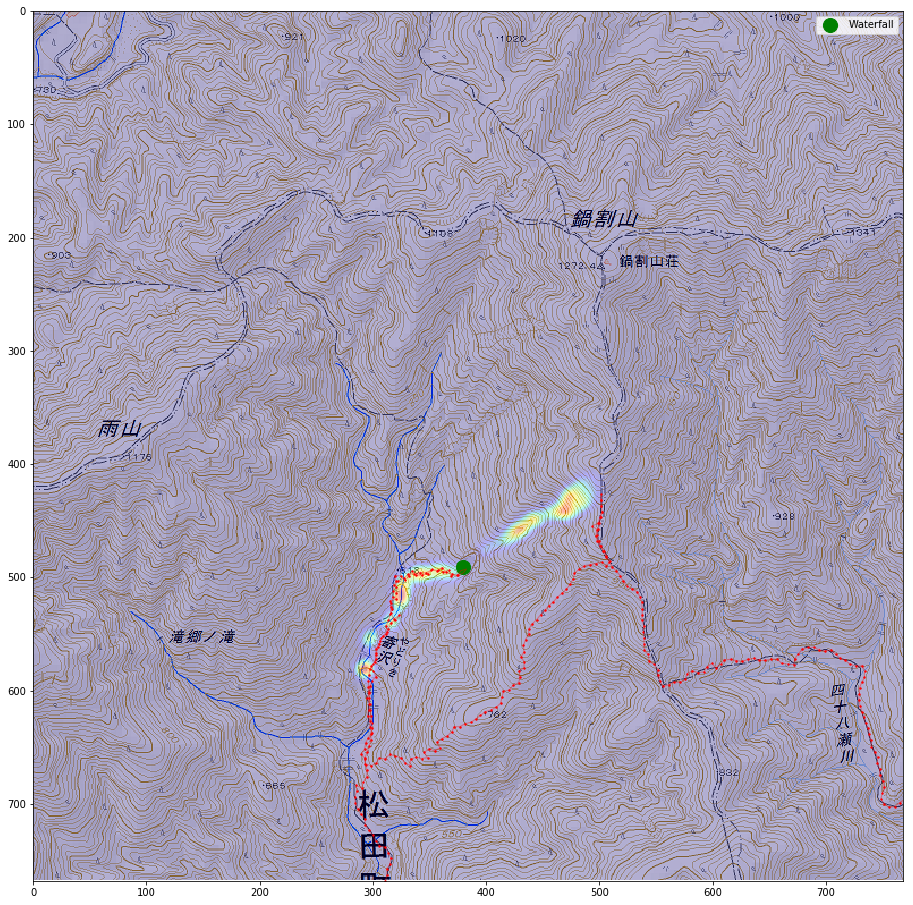

In [141]:
figsize(16, 16)
fig,ax = plt.subplots(1)
ax.imshow(mixed_map) # 地図+ヒートマップ
plt.scatter(gps_log[:, 0], gps_log[:, 1], color="red", s=2) # GPSのログを点でプロット
route = Polygon(gps_log, fill=False, closed=False, ec="red", lw=1, alpha=0.4) # GPSのログを半透明の折れ線でプロット
ax.add_patch(route)
ax.scatter(waterfall_x, waterfall_y, color="green", s=200, label="Waterfall") # 滝の位置をプロット

plt.legend()
ax.set_xlim(0, mixed_map.shape[1])
ax.set_ylim(mixed_map.shape[0], 0) # 順番を逆にすると上下反転してしまう

ポリタンクは悪路すぎて近づけなかったエリアに存在するものと思われる。